In [1]:
# Basic packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os

# JAX-related
import jax
from jax import random
import jax.numpy as jnp
from jax.scipy.stats import norm

# Numpyro-related
import numpyro
from numpyro.infer import MCMC, NUTS

numpyro.enable_x64()

c:\Users\bodlukas\Anaconda3\envs\numpyro\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Specify settings for inference
- im_string: IM used to estimate fragility functions. For PGA use 'PGA', for SA(T=0.3s) use 'SAT0_300'.
- GMM: GMM that was used to obtain mean, between-event and within-event residuals of logIM at the sites. See AAAAAAA
- SCM: Spatial correlation model which is used to condition the IM distribution on station data. For now `modules.spatialcorrelation` contains implementations of EspositoIervolino2012 and BodenmannEtAl2023, but users can easily add additional models by following the documentation.
- list_ds: Ordered list with possible damage states (including damage state 0!)
- list_bc: List with considered building classes for which to estimate fragility functions

The MCMC-specific settings are directly explained below.

In [2]:
path_data = os.getcwd() + os.sep + 'data_twodim' + os.sep

args = {
    'im_string': 'SAT0_300',
    'GMM': 'BindiEtAl2011',
    'SCM': 'EspositoIervolino2012', 
    'list_ds': [0, 1, 2, 3], 
    'list_bc': ['A', 'B', 'C'], 
    'mcmc_seed': 0, # Seed for MCMC
    'mcmc': {
        'num_samples': 750, # Number of samples per Markov chain
        'num_warmup': 1000, # Number of warmup steps per Markov chain
        'num_chains': 4 # Number of Markov chains    
            }
        }

### Import damage survey data

This fictitious damage survey data contains information from 4200 buildings. For each building the data set provides:
- coordinates in Longitude and Latitude (decimal degrees)
- building class 
- damage state
- vs30: time-average shear wave velocity in the upper-most 30 meters of soil in m/s

Following additional variables were computed from the rupture information and using a ground motion model (GMM)
- epiazimuth: Azimuth with respect to epicenter in degrees (required by BodenmannEtAl2023 correlation model)
- mu_logIM: Mean of logIM as obtained from a GMM
- tau_logIM: Standard deviation of logIM between-event residual as obtained from a GMM
- phi_logIM: Standard deviation of logIM within-event residual as obtained from a GMM

In [3]:
df = pd.read_csv(path_data + 'survey_im' + im_string + '_' + gmm_combo + '.csv')
df

,id,Longitude,Latitude,vs30,epiazimuth,mu_logIM,tau_logIM,phi_logIM,BuildingClass,DamageState
0,0,13.430660,42.302485,529.93370,44.626553,-0.565073,0.501964,0.66775,A,0
1,1,13.288765,42.396429,509.20395,164.165307,-0.677659,0.501964,0.66775,A,3
2,2,13.365190,42.365922,450.50436,169.837767,-0.565073,0.501964,0.66775,A,3
3,3,13.402773,42.348720,453.86163,177.774937,-0.565073,0.501964,0.66775,A,1
4,4,13.400559,42.352410,455.24070,179.724174,-0.565073,0.501964,0.66775,A,3
...,...,...,...,...,...,...,...,...,...,...
4195,4195,13.395423,41.972135,536.46490,44.474262,-2.146303,0.501964,0.66775,C,0
4196,4196,13.390121,41.963362,622.23680,44.986776,-2.188677,0.501964,0.66775,C,0
4197,4197,13.567571,42.245930,425.86472,347.998133,-0.677665,0.501964,0.66775,C,2
4198,4198,13.412729,42.059801,431.81610,43.196936,-1.681242,0.501964,0.66775,C,0


In [94]:
from modules.utils import Sites
# Create sites
survey_sites = Sites(
    coordinates = df[['Longitude', 'Latitude']].values,
    # The correlation model of BodenmannEtAl2023 requires additional inputs:
    # epiazimuth = df['epiazimuth'].values,
    # vs30 = df['vs30'].values,
    mu_logIM = df['mu_logIM'].values,
    tau_logIM = df['tau_logIM'].values,
    phi_logIM = df['phi_logIM'].values,
)
# Extract observed building classes and damage states
obs_BC = pd.Categorical(df.BuildingClass.copy(), categories = args['list_bc'], 
                        ordered=True)
obs_DS = pd.Categorical(df.DamageState.copy(), categories = args['list_ds'], 
                        ordered = True)

AttributeError: 'DataFrame' object has no attribute 'BuildingClass'

### Import station data

This fictitious station data set contains information from 64 stations. For each station the data set provides the same attributes as for the surveyed buildings with the exception of BuildingClass and DamageState. Additionally it provides the observed logIM value as obtained from the ground motion recordings (obs_logIM). 

In [92]:
df = pd.read_csv(path_data + 'stations_im' + im_string + '_' + gmm_combo + '.csv')
df

,network_code,station_code,Longitude,Latitude,vs30,epiazimuth,mu_logIM,tau_logIM,phi_logIM,obs_logIM
0,BA,SANL,16.271763,40.252750,443.000000,353.142741,-6.290024,0.501964,0.66775,-5.798707
1,BA,TTS,15.723605,40.601345,175.000000,354.267481,-5.724108,0.501964,0.66775,-5.672250
2,IT,ANT,13.078598,42.418110,912.000000,149.814260,-2.185333,0.501964,0.66775,-2.927012
3,IT,AQA,13.339298,42.375530,549.000000,166.596045,-0.565073,0.501964,0.66775,-0.297195
4,IT,AQG,13.337026,42.373474,696.000000,164.839746,-0.565073,0.501964,0.66775,-0.114087
...,...,...,...,...,...,...,...,...,...,...
59,IV,GUMA,13.335200,43.062700,488.000000,214.400740,-3.347616,0.501964,0.66775,-2.841704
60,IV,SENI,13.233100,43.705200,242.000000,213.954197,-4.392700,0.501964,0.66775,-2.870504
61,MN,AQU,13.401930,42.353880,455.862823,182.342906,-0.565073,0.501964,0.66775,-0.909393
62,SL,BOJS,15.251800,45.504300,760.000000,241.691966,-6.733770,0.501964,0.66775,-6.226881


In [93]:
# Create sites
station_sites = Sites(
    coordinates = df[['Longitude', 'Latitude']].values,
    mu_logIM = df['mu_logIM'].values,
    tau_logIM = df['tau_logIM'].values,
    phi_logIM = df['phi_logIM'].values,
)

# Extract observed logIM values
obs_logIM = df['obs_logIM'].values

### Condition IM on station data

Compute $p(\mathbf{im}_\mathcal{B}|\mathbf{im}_\mathcal{S}, \mathbf{rup})=\mathcal{LN}(\boldsymbol{\mu}_{\mathcal{B}|\mathcal{S}}, \boldsymbol{\Sigma}_{\mathcal{BB}|\mathcal{S}})$. 

For inference, only $\boldsymbol{\mu}_{\mathcal{B}|\mathcal{S}}$ and the lower Cholesky decomposition $\mathbf{L}\mathbf{L}^\top = \boldsymbol{\Sigma}_{\mathcal{BB}|\mathcal{S}}$ is required. 

In [21]:
# Spatial correlation model
if args['SCM'] == 'EspositoIervolino2012':
    from modules.spatialcorrelation import EspositoIervolino2012
    scm = EspositoIervolino2012(args['im_string'])
elif args['SCM'] == 'BodenmannEtAl2023':
    from modules.spatialcorrelation import BodenmannEtAl2023
    scm = BodenmannEtAl2023(args['im_string'])

# Computations
from modules.shakemap import GPR
gpr = GPR(SCM=scm) # Initialize
gpr.fit(station_sites, obs_logIM, jitter=1e-4) # Add station data
mu_B_S, Sigma_BB_S = gpr.predict(survey_sites) # Compute parameters
L_BB_S = np.linalg.cholesky(Sigma_BB_S) # Lower Cholesky transform

# Delete the covariance matrix to save memory
del Sigma_BB_S

### Inference

In [118]:
from modules.inference import Model_MCMC

# Initialize NUTS sampler
rng_key = random.PRNGKey(args['mcmc_seed'])
mcmc = MCMC(NUTS(Model_MCMC), **args['mcmc'])

# Perform MCMC
mcmc.run(rng_key, mu = mu_B_S, L = L_BB_S, 
        ds = obs_DS, bc = obs_BC.codes,
        n_ds = len(args['list_ds']), 
        n_bc = len(args['list_bc']))

C:\Users\bodlukas\AppData\Local\Temp\ipykernel_9588\2388045442.py:3: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  nuts = MCMC( NUTS(Model_MCMC), **mcmc_args )
sample: 100%|██████████| 1750/1750 [17:07<00:00,  1.70it/s, 31 steps of size 1.34e-01. acc. prob=0.86]  


In [243]:
samples.keys()

dict_keys(['beta', 'deltas', 'eta1', 'z'])

In [129]:
def get_etas_betas(samples, n_bc):
  etas = []
  betas = []
  for bc in range(n_bc):
    etas_temp = np.append(samples['eta1'][:, bc],
                        samples['eta1'][:, bc] +
                        np.cumsum(samples['deltas'][:, bc, :], axis=-1), axis=-1)
    beta = samples['beta'][:, bc]
    etas.append(etas_temp)
    betas.append(beta)
  return np.stack(etas), np.stack(betas)

etas, betas = get_etas_betas(samples, n_bc=args['n_bc'])

In [137]:
np.savez('res_twodim_frag.npz',
         etas = etas, betas = betas)

In [143]:
logIM_B = (mu_B_S[:,None] + L_BB_S @ samples['z'].T)
mu_logIM = np.mean(logIM_B, axis=1)
std_logIM = np.std(logIM_B, axis=1)

In [145]:
np.savez('res_twodim_logIM.npz',
         mean = mu_logIM, std = std_logIM)

In [164]:
samples['z'].shape

(3000, 4200)

In [22]:
from scipy import linalg
class PosteriorPredictiveIM(object):
    '''
    This object is used to compute the distribution of logIM conditional on 
    observed IMs at seismic network stations.

    The mean and the covariance functions are functions similar to getMean and 
    getCov from above.
    '''

    def __init__(self, GPR: GPR, survey_sites: Sites):
        '''
        Args:
            GPR (GPR): Shake map computer

            survey_sites (Sites): Surveyed building sites
        '''
        self.gpr = GPR
        self.survey_sites = survey_sites
        self._precompute()
    
    def sample(self, rng_keys, target_sites, z_samples, L_BB_S, full_cov=True):
        '''
        Sample logIM values from the posterior predictive at the target_sites
        For each sample from the posterior of logIM at survey sites:
            - compute the posterior predictive at target sites
            - generate one sample from the posterior predictive

        Args:
            rng_keys (): random number generator from Numpyro

            target_sites (Sites): Sites at which we draw samples from the posterior predictive

            z_samples (ArrayLike): Posterior samples of z
                dimension: (n_samples, n_survey_sites)

            L_BB_S (ArrayLike): Lower Cholesky Decomposition of Sigma_BB_S

            full_cov (bool): if true, generate samples from the multivariate posterior predictive
                            if false, generate samples from the univariate posterior predictive

        Returns:
            sam_logIM (ArrayLike): Samples from the posterior predictive IM at the target_sites
                dimension: (n_samples, n_target_sites)
        '''
        # Covariance matrix between prior logIM at target and survey sites
        Sigma_TB = gpr.getCov(target_sites, self.survey_sites)
        # Covariance matrix between prior logIM at station and target sites
        Sigma_ST = gpr.getCov(self.gpr.sites, target_sites)
        # Mean and covariance matrix of logIM at target sites conditional on station data
        mu_T_S, Sigma_TT_S = gpr.predict(target_sites, full_cov = full_cov)

        sam_logIM = self._sampler(rng_keys, z_samples, Sigma_TB, Sigma_ST, 
                               mu_T_S, Sigma_TT_S, L_BB_S, full_cov=full_cov)
        return sam_logIM

    def _precompute(self):
        Sigma_SS = self.gpr.getCov(self.gpr.sites)
        self.L_SS = np.linalg.cholesky(Sigma_SS)
        # (L_SS)^-1 Sigma_SB
        self.A_SB = linalg.solve_triangular(self.L_SS,
                    self.gpr.getCov(self.gpr.sites, survey_sites),
                    lower=True)

    def _sampler(self, rng_key, z_samples, Sigma_TB, Sigma_ST, 
                               mu_T_S, Sigma_TT_S, L_BB_S, full_cov):
        num_samples = z_samples.shape[0]
        # (L_SS)^-1 Sigma_ST
        A_ST = jax.scipy.linalg.solve_triangular(self.L_SS, Sigma_ST, lower=True)
        # Covariance matrix between logIM at target and survey sites conditional on station data
        Sigma_TB_S = Sigma_TB - (A_ST.T @ self.A_SB)
        # (L_BB_S)^-1 Sigma_BT_S
        A_BT_S = jax.scipy.linalg.solve_triangular(L_BB_S, Sigma_TB_S.T, lower=True)
        # Mean of logIM at target sites conditional on posterior samples z 
        mu_T_S_DS = mu_T_S + (A_BT_S.T @ (z_samples.T)).T                 
        if full_cov:
            # Covariance matrix of logIM at target sites conditional on station and damage data
            Sigma_TT_S_DS = Sigma_TT_S - (A_BT_S.T @ A_BT_S)
            sam_logIM = (mu_T_S_DS + random.multivariate_normal(rng_key, jnp.zeros_like(mu_T_S), 
                                                          Sigma_TT_S_DS, shape=(num_samples,)))
        else:
            # Standard deviation of logIM at target sites conditional on station and damage data
            sigma_T_S_DS = jnp.sqrt(Sigma_TT_S - jnp.sum(A_BT_S**2, axis=0))
            sam_logIM = (mu_T_S_DS + sigma_T_S_DS*random.normal(rng_key, shape=mu_T_S_DS.shape))
        return sam_logIM
    

In [ ]:
postpredIM = PosteriorPredictiveIM(GPR = gpr, survey_sites = survey_sites)

In [ ]:
rng_key = random.PRNGKey(2)
rng_keys = random.split(rng_key, samples['z'].shape[0])
sam_logIM = postpredIM.sample(rng_key, map_sites, samples['z'], L_BB_S, full_cov=False)

In [ ]:
np.savez('res_twodim_logIM_map.npz',
         mean = np.mean(sam_logIM, axis=0), 
         std = np.std(sam_logIM, axis=0))

In [89]:
res = np.load('results/aquila_obs/mcmc_frag_trueAq_seedfold31_nfolds4_fold1_imT0_300_gmmCY2014.npz')

In [90]:
import xarray as xr

NpzFile 'results/aquila_obs/mcmc_frag_trueAq_seedfold31_nfolds4_fold1_imT0_300_gmmCY2014.npz' with keys: etas_tildes, betas

In [30]:
df = pd.read_csv(path_data + 'gridmap_im' + im_string + '_' + gmm_combo + '.csv')
# Create sites
map_sites = Sites(
    coordinates = df[['Longitude', 'Latitude']].values,
    mu_logIM = df['mu_logIM'].values,
    tau_logIM = df['tau_logIM'].values,
    phi_logIM = df['phi_logIM'].values,
)
sh = (len(df.row.unique()), len(df.col.unique()))

In [25]:
mu_T_S, var_T_S = gpr.predict(map_sites, full_cov=False)
std_T_S = np.sqrt(var_T_S)

In [32]:
res = np.load('res_twodim_logIM_map.npz')
mu_T_S_DS = res['mean']
std_T_S_DS = res['std']

In [36]:
X = map_sites.coor[:, 0].reshape(sh)
Y = map_sites.coor[:, 1].reshape(sh)

In [37]:
Z = mu_T_S.reshape(sh)

In [40]:
Z.shape

(49, 29)

In [57]:
[max(i) for i in vals]

[0.02645045393560841, 0.32550119291989005]

In [58]:
[min(i) for i in vals]

[-2.1167877529099135, -2.0599104715476546]

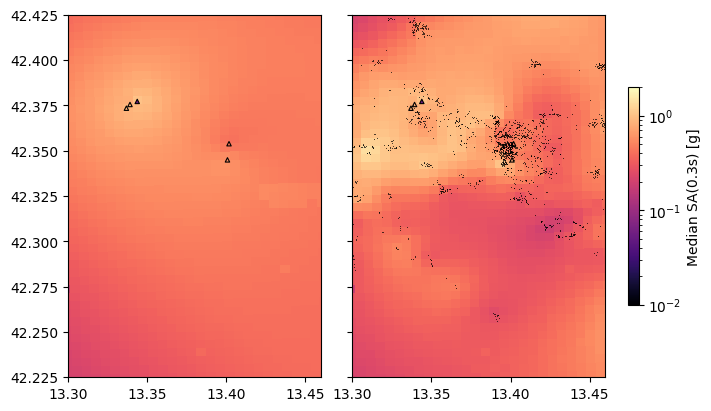

In [88]:
X = map_sites.coor[:, 0].reshape(sh)
Y = map_sites.coor[:, 1].reshape(sh)
norma = mpl.colors.LogNorm(vmin=0.01, vmax=2)
cmap = plt.get_cmap('magma')
fig, axs = plt.subplots(1, 2, figsize=(7,4), sharey=True,
                        constrained_layout=True)
vals = [mu_T_S, mu_T_S_DS]
for i, ax in enumerate(axs):
    Z = np.exp(vals[i].reshape(sh))
    im = ax.pcolormesh(X,Y,Z,  norm=norma, cmap=cmap)
    ax.scatter(station_sites.coor[:,0], station_sites.coor[:,1], c = obs_logIM,
                   marker='^', edgecolor='black', s=10, lw=0.8, norm = norma, cmap=cmap)
    if i == 1: 
        ax.scatter(survey_sites.coor[:,0], survey_sites.coor[:,1], 
                   marker='.', color='black', s=0.8, lw=0.2)
    ax.set_xlim([13.3, 13.46])
    ax.set_ylim([42.225, 42.425])
    # ax.set_aspect('equal')
cbar = fig.colorbar(im, ax=axs[:], 
             orientation ='vertical', shrink=0.6, 
             label='Median SA(0.3s) [g]', pad=0.035,)
plt.show()

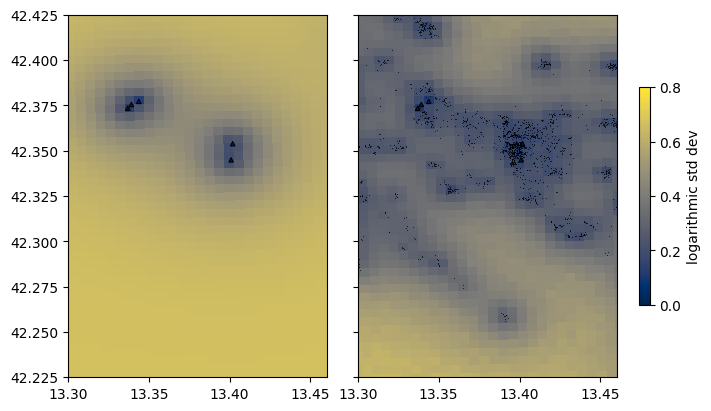

In [87]:
X = map_sites.coor[:, 0].reshape(sh)
Y = map_sites.coor[:, 1].reshape(sh)
norma = mpl.colors.Normalize(vmin=0.0, vmax=0.8)
cmap = plt.get_cmap('cividis')
fig, axs = plt.subplots(1, 2, figsize=(7,4), sharey=True,
                        constrained_layout=True)
vals = [std_T_S, std_T_S_DS]
for i, ax in enumerate(axs):
    Z = vals[i].reshape(sh)
    im = ax.pcolormesh(X,Y,Z,  norm=norma, cmap=cmap)
    ax.scatter(station_sites.coor[:,0], station_sites.coor[:,1], c = obs_logIM,
                   marker='^', edgecolor='black', s=10, lw=0.8, norm = norma, cmap=cmap)
    if i == 1: 
        ax.scatter(survey_sites.coor[:,0], survey_sites.coor[:,1], 
                   marker='.', color='black', s=0.8, lw=0.2)
    ax.set_xlim([13.3, 13.46])
    ax.set_ylim([42.225, 42.425])
    # ax.set_aspect('equal')
cbar = fig.colorbar(im, ax=axs[:], 
             orientation ='vertical', shrink=0.6, 
             label='logarithmic std dev', pad=0.035,)
plt.show()

Array([[  4.11547768,   4.26718952,   4.34432785, ...,   0.59582679,
          0.44179059,   0.28838175],
       [ -6.66926156,  -6.84672796,  -6.89403775, ...,  -1.61086368,
         -1.44790121,  -1.29273452],
       [ -3.8119606 ,  -4.10064686,  -4.36954728, ...,   1.60453844,
          1.60683487,   1.60324303],
       ...,
       [-13.16158114, -13.28457683, -13.30787742, ..., -11.49162743,
        -11.37281344, -11.25933949],
       [-15.2597984 , -15.39761916, -15.48779439, ..., -19.48356697,
        -19.47056344, -19.45807153],
       [ 11.67772923,  11.97355215,  12.28931269, ...,   6.96505289,
          6.98348105,   7.00450944]], dtype=float64)

In [212]:
random.multivariate_normal(rng_key, jnp.zeros_like(mutest), Covtest, shape=(3000,)).shape

(3000, 1421)

In [218]:
random.normal(rng_key, shape=(3000, map_sites.n_sites)).shape

(3000, 1421)

In [240]:
postpredIM = PosteriorPredictiveIM(GPR=gpr, survey_sites=survey_sites)

In [241]:
rng_key = random.PRNGKey(2)
rng_keys = random.split(rng_key, samples['z'].shape[0])
sam_logIM = postpredIM.sample(rng_key, map_sites, samples['z'], L_BB_S, full_cov=False)

In [236]:
sam_logIM.shape

(3000, 1421)

In [237]:
np.savez('res_twodim_logIM_map.npz',
         mean = np.mean(sam_logIM, axis=0), 
         std = np.std(sam_logIM, axis=0))

In [242]:
np.exp(np.mean(sam_logIM, axis=0))

array([0.21569658, 0.20940965, 0.21419629, ..., 0.48618371, 0.4931727 ,
       0.49429619])

In [191]:
np.exp(np.mean(sam_logIM, axis=0))

array([0.21731745, 0.21071297, 0.21620596, ..., 0.48952578, 0.49852432,
       0.50163692])

In [180]:
sh = (len(dftarget.row.unique()), len(dftarget.col.unique()))
X = dftarget.Longitude.values.reshape(sh)
Y = dftarget.Latitude.values.reshape(sh)

In [169]:
dftarget = dftarget[(dftarget.Longitude >= 13.3) & (dftarget.Longitude <= 13.47) & 
         (dftarget.Latitude >= 42.21) & (dftarget.Latitude <= 42.43)].copy()

In [171]:
sh = (dftarget.row.max()+1, dftarget.col.max()+1)
# Lons = d_sm.Longitude.values.reshape(sh)
# Lats = d_sm.Latitude.values.reshape(sh)
X = dftarget.Longitude.values.reshape(sh)
Y = dftarget.Latitude.values.reshape(sh)

ValueError: cannot reshape array of size 1374 into shape (146,83)

In [170]:
dftarget

,col,row,Longitude,Latitude,x,y,vs30,mu_logIM,phi,tau,mu_logPGA,phi_logPGA,tau_logPGA
20813,55,97,13.300450,42.426869,4.593412e+06,2.152815e+06,409.97134,-1.546703,0.66775,0.396045,-1.537262,0.66775,0.396045
20814,56,97,13.306512,42.426959,4.593911e+06,2.152847e+06,454.24365,-1.527739,0.66775,0.396045,-1.518299,0.66775,0.396045
20815,57,97,13.312573,42.427048,4.594411e+06,2.152879e+06,455.29028,-1.509383,0.66775,0.396045,-1.499942,0.66775,0.396045
20816,58,97,13.318634,42.427137,4.594910e+06,2.152910e+06,456.58508,-1.491691,0.66775,0.396045,-1.482250,0.66775,0.396045
20817,59,97,13.324696,42.427226,4.595410e+06,2.152942e+06,457.61502,-1.474723,0.66775,0.396045,-1.465282,0.66775,0.396045
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31108,78,145,13.445201,42.212701,4.606360e+06,2.129659e+06,681.66200,-1.381879,0.66775,0.396045,-1.372438,0.66775,0.396045
31109,79,145,13.451242,42.212783,4.606859e+06,2.129690e+06,456.64606,-1.371883,0.66775,0.396045,-1.362443,0.66775,0.396045
31110,80,145,13.457283,42.212864,4.607359e+06,2.129722e+06,543.55800,-1.365146,0.66775,0.396045,-1.355705,0.66775,0.396045
31111,81,145,13.463325,42.212945,4.607859e+06,2.129754e+06,672.98550,-1.361755,0.66775,0.396045,-1.352315,0.66775,0.396045


In [ ]:
dftarget[['col', 'row']]

In [162]:
from scipy import linalg
# Precomputed Quantities
Sigma_SS = gpr.getCov(gpr.sites)
L_SS = np.linalg.cholesky(Sigma_SS)
A_SB = linalg.solve_triangular(L_SS,
                gpr.getCov(gpr.sites, survey_sites),
                lower=True)

In [ ]:
def compute_mu_Sigma_pred(sites_new, sites, gpr, full_cov=True):
  Sigma_TB = gpr.getCov(sites_new, sites)
  Sigma_ST = gpr.getCov(gpr.sites, sites_new)
  A_ST = jax.scipy.linalg.solve_triangular(L_SS, Sigma_ST, lower=True)
  Sigma_TB_S = Sigma_TB - (A_ST.T @ A_SB)
  mu_T_S, Sigma_TT_S = gpr.predict(sites_new, full_cov=full_cov)
  return mu_T_S, Sigma_TB_S, Sigma_TT_S

In [ ]:
def gp_predict(keys, A, mun, Knn, samples, mu, i, full_cov=True, eps=1e-6):
    fmean = mun + A.T @ (samples['z'][i])
    if full_cov:
      fvar =  Knn - A.T @ A
      sam = random.multivariate_normal(keys[i], fmean, fvar)
    else:
      fstd = np.sqrt(Knn - np.sum(A**2, axis=0))
      sam = fmean + fstd*random.normal(keys[i])
    return sam

In [ ]:
mu_T_S, Sigma_TB_S, Sigma_TT_S = compute_mu_Sigma_pred(sites_new, survey_sites, gpr, full_cov=False)
A = jax.scipy.linalg.solve_triangular(L_BB_S, Sigma_TB_S.T, lower=True)
fsam =  np.stack([gp_predict(rng_keys, A, mu_T_S, Sigma_TT_S, samples, mu_B_S, i, full_cov=False)
                    for i in trange(samples['z'].shape[0])])

In [ ]:
from scipy import linalg
# Precomputed Quantities
jitter_gpr = 1e-4
K_gpr = gpr.kernel(gpr.args_im, gpr.sites, gpr.gmm_res)
K_gpr = K_gpr + np.eye(survey_sites.n_sites)*jitter_gpr
L_gpr = np.linalg.cholesky(K_gpr)
A_I = linalg.solve_triangular(L_gpr,
                gpr.kernel(gpr.args_im, gpr.sites, gpr.gmm_res, sites, gmm_res),
                lower=True)

In [ ]:
def compute_mu_Sigma_pred(sites_new, gmm_res_new, sites, gmm_res,
                        gpr, full_cov=True, jitter=1e-6):
  K_IT = gpr.kernel(gpr.args_im, sites, gmm_res, sites_new, gmm_res_new)
  K_TS = gpr.kernel(gpr.args_im, sites_new, gmm_res_new, gpr.sites, gpr.gmm_res)
  A_T = jax.scipy.linalg.solve_triangular(L_gpr, K_TS.T, lower=True)
  Sigma_TI = K_IT.T - (A_T.T @ A_I)
  mu_T, Sigma_TT = gpr.predict(sites_new, gmm_res_new, full_cov=full_cov)
  return mu_T, Sigma_TI, Sigma_TT

In [ ]:
def gp_predict(keys, A, mun, Knn, samples, mu, i, full_cov=True, eps=1e-6):
    fmean = mun + A.T @ (samples['z'][i])
    if full_cov:
      fvar =  Knn - A.T @ A
      sam = random.multivariate_normal(keys[i], fmean, fvar)
    else:
      fstd = np.sqrt(Knn - np.sum(A**2, axis=0))
      sam = fmean + fstd*random.normal(keys[i])
    return sam

In [ ]:
fmean = []; fstd = []; fq05 = []; fq95 = []
# Ssites_new, Sgmm_res_new = [prepare_sites(df_test, im_args) for df_test in dfs_test]
# for df_test in dfs_test:
#   # df_test = dfs_test[1]
#   if len(df_test)==0: continue
#   sites_new, gmm_res_new = prepare_sites(df_test, im_args)
rng_key = random.PRNGKey(2)
rng_keys = random.split(rng_key, samples['z'].shape[0])
for sites_new, gmm_res_new in prepared_dfs:
  if sites_new['X'].shape[0]==0: continue
  mu_T, Sigma_TI, Sigma_TT = compute_mu_Sigma_pred(sites_new, gmm_res_new, sites, gmm_res,
                                gpr, full_cov=False)
  A = jax.scipy.linalg.solve_triangular(L, Sigma_TI.T, lower=True)
  fsam =  np.stack([gp_predict(rng_keys, A, mu_T, Sigma_TT, samples, mu, i, full_cov=False)
                        for i in trange(samples['z'].shape[0])])
  fmean.append(np.round(np.mean(fsam,axis=0),4))
  fstd.append(np.round(np.std(fsam,axis=0),4))
  fq05.append(np.round(np.quantile(fsam, 0.05, axis=0),4))
  fq95.append(np.round(np.quantile(fsam, 0.95, axis=0),4))

In [156]:
np.quantile(betas, 0.05, axis=1)

array([0.53579093, 0.70557023, 0.63584469])

In [155]:
np.quantile(betas, 0.95, axis=1)

array([0.68228887, 0.90252083, 0.83434432])

In [120]:
thetas_true = np.array([[0.25, 0.41, 0.66],
                        [0.37, 0.65, 1.05],
                        [0.52, 0.93,  1.49]])
betas_true = np.array([[0.59],[0.75], [0.75]])

In [134]:
np.log(thetas_true)/betas_true

array([[-2.34965146, -1.51118325, -0.70426346],
       [-1.3256697 , -0.57437722,  0.06505355],
       [-0.87190196, -0.09676092,  0.53170149]])

In [136]:
np.mean(betas,axis=1)

array([0.60643165, 0.80005068, 0.73110655])

In [135]:
np.mean(etas, axis=1)

array([[-2.18068211, -1.45557603, -0.6533518 ],
       [-1.23169998, -0.4881678 ,  0.15181286],
       [-0.88833159, -0.20768349,  0.4770438 ]])

In [153]:
np.mean(np.exp(etas*betas[:,:,None]),axis=1)

array([[0.26872712, 0.41684399, 0.67824762],
       [0.37654504, 0.68292607, 1.14188113],
       [0.52715756, 0.86794139, 1.43603069]])

In [133]:
np.exp(np.mean(etas, axis=1) * np.mean(betas, axis=1))

array([[0.26648571, 0.31206787, 0.62022697],
       [0.47381333, 0.67667852, 1.11738527],
       [0.58349909, 0.84691299, 1.41732296]])

In [121]:
import matplotlib.pyplot as plt
cmap = plt.get_cmap('inferno_r')
colors = cmap([0.15, 0.4, 0.85])

vc = 0
im = np.linspace(0.001,1,500)
logim = np.log(im).reshape(-1,1)
fig, ax = plt.subplots()
for dm in range(2):
  # Compute mean parameters
  beta_m = np.mean(betas[vc,:])
  # etas_m = onp.mean(etas[vc,:,dm] * betas[vc,:])
  etas_m = np.mean(etas[vc,:,dm])
  # Compute all sampled functions
  ccdf = norm.cdf(logim/betas[vc,:].reshape(1,-1) - etas[vc,:,dm].reshape(1,-1))
  # 5% and 95% quantiles of all sampled functions at each im
  qs = np.quantile(ccdf, [0.05, 0.95], axis=1)
  plt.fill_between(im, qs[1,:], qs[0,:], alpha=0.2, color=colors[dm])
  if dm == 1: lab1 = 'MCMC: mean'; lab2 = 'true'
  else: lab1 = lab2 = None
  # plt.plot(im, norm.cdf((logim-etas_m)/beta_m), color=colors[dm], ls='-', label=lab1)
  plt.plot(im, norm.cdf(logim/beta_m - etas_m), color=colors[dm], ls='-', label=lab1)
  plt.plot(im, norm.cdf((logim-np.log(thetas_true[vc,dm]))/betas_true[vc,0]), color=colors[dm], ls='--', label=lab2)
ax.set_ylim([0,1])
ax.set_xlim([0.01,1])
ax.set_ylabel('Exceedance probability')
ax.set_xlabel('PGA [g]')
ax.legend()
# ax.set_xscale('log')
plt.show()

ModuleNotFoundError: No module named 'matplotlib'